
&nbsp;

<font size="8"> <b>Data-driven approach</b></font> <br>

&nbsp;

<font size="6"> <b>Supervised learning for predicting sugarcane yield</b></font> 

-------------------------------------------------------------------------------

&nbsp;

# Project pipeline 

&nbsp;

<figure>

<img src='storytelling/pipeline.png' alt="drawing" width="1000"/>
<figcaption align='middle'><b>Fig.1</b> - Pipeline of a data science project.</figcaption>

</figure>

<!---
![Caption](https://www.canva.com/design/DAEpSP9Hqp8/A17FuzSAQKwr-F8RRZx5Mw/view?utm_content=DAEpSP9Hqp8&utm_campaign=designshare&utm_medium=link&utm_source=publishsharelink)
-->

# Business question

&nbsp;

The main problem to deal here is how to forecast the sugarcane production in 2020 (assuming as current year).

**Why producers/sugarcane mill owners want to forecast the production?** 

To have important insights for a better strategy of market, logistic, and industrial process. 

<!---
This allows the managers have a better strategy to plan sales, buy inputs, and
crop management. In other words, the decision take is done increasing the profit.
-->


# Business understanding
&nbsp;

We can see sugarcane fields everywhere in Brazil.

Brazilian sugarcane production is the largest in the world.

2% of the Brazilian gross domestic product (GDP) is from sugarcane products, we have:
  * sugar (food), 
  * ethanol (fuel), and 
  * cachaça (drink).

&nbsp;
 
 <figure>

<img src='storytelling/ColheitaSaoMartinho.jpg' alt="drawing" width="1000"/>
<figcaption align='middle'><b>Fig.2</b> - Sugarcane harvest.</figcaption>

</figure>
 



# Data acquisition
&nbsp;
For this project the dataset was provided as a `.csv` file.  

## Dataset variables

&nbsp;

  * `block`: identification of block (ensemble of plots);
  * `plot`: identification of plot within n-block;
  * `crop_year`: year of crop growth;
  * `area`: plot area;
  * `harvest_day`: day of harvest;
  * `tch_block`: tonnes of sugarcane per hectare (TCH), t.ha$^{-1}$;
  * `NDVI_bn`: normalized difference vegetation index (NDVI) n months before harvest.

**Output**: `tch_block`; <br>
**Features**: `NDVI_bn`, `block`, `plot`, `crop_year`, `area`, `harvest_day`.




## Importing libraries

In [ ]:
import sweetviz as sv
import matplotlib.pyplot as plt
%matplotlib inline
#from jupyterthemes import jtplot
#jtplot.style(theme='grade3',context='notebook', ticks=True,fscale=1.4, gridlines='--')

import seaborn as sn
from yellowbrick.regressor import residuals_plot
import pickle
import requests

import pandas as pd
import numpy as np
from sqlalchemy import create_engine


from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.linear_model import ElasticNet, Lasso, Ridge, ARDRegression, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


## Reading the raw dataset

In [ ]:
df = pd.read_csv('datasets/dataset_case_DS.csv')
df = df.sort_values(["bloco", "talhao", "safra"], ascending=(True, True, True))


## Arranging the dataset

In [ ]:
# Renaming columns
df.columns = ['Unnamed: 0', 'block', 'plot', 'crop_year', 'area', 'harvest_day',
       'tch_block', 'NDVI_b01', 'NDVI_b02', 'NDVI_b03', 'NDVI_b04', 'NDVI_b05',
       'NDVI_b06', 'NDVI_b07', 'NDVI_b08', 'NDVI_b09', 'NDVI_b10', 'NDVI_b11',
       'NDVI_b12']

# Types of variables
print(df.dtypes)
df.head()

In [ ]:
# changing data types
df['harvest_day'] = pd.to_datetime(df['harvest_day'])

print(df.info(), df.describe())



# Data cleaning

In [ ]:
# Checking null values of TCH
df.loc[pd.isna(df["tch_block"]), :]


In [ ]:
# Removing null values of dataset
# area and harvest_day have null values too
df = df[df.tch_block.notna()]


In [ ]:
# Checking null area values 
df.loc[pd.isna(df["area"]), ['crop_year']]

In [ ]:
# Removing outliers
df = df.loc[df['tch_block'] < 150]

## NDVI gap filling

In [ ]:
# NDVI data frame
NDVI = df.filter(regex='^NDVI')


In [ ]:
# Using KNNimputer 
NDVI_imputer = KNNImputer(n_neighbors=2, weights="uniform")
NDVI_fill = pd.DataFrame(NDVI_imputer.fit_transform(NDVI))
NDVI_fill.columns = NDVI.columns
NDVI_fill.index = NDVI.index

In [ ]:
# Data frame updating with new NDVI values
df = pd.concat([df.iloc[:, 1:7], NDVI_fill], axis=1)


In [ ]:
# Creating a new feature due to the importance of split the crop year into sugarcane plant and ratoon
df['sc_plant'] = np.where(df.tch_block > df.groupby(['block', 'plot'])[
    'tch_block'].transform('quantile', 0.75), 1, 0)

In [ ]:
# Total area harvested for each block
area_block = df.groupby(['block','crop_year'])['area'].sum()
area_block

In [ ]:
# Merging area_block in the main dataframe 
df = pd.merge(df, area_block, how='left', on=['block', 'crop_year'])
df.head()


## Final descriptive statistic



In [ ]:
print(df.info(),df.describe())



In [ ]:
# Checking a block
df[df.block == 1237]

## Saving as file-based database

In [ ]:
# Creating a SQLite database 
engine = create_engine('sqlite:////home/wagner/MEGA/WaterTruth/wagner_portfolio/Project3/datasets/dataset_final.db', echo=False)

# Saving dataframe as SQL database
df.to_sql('dataset_final', con=engine, if_exists='replace', index = False)

# Exploratory data analysis
&nbsp;

Two main aims: 
- Create actionable insights for business team, and; 
- Understanding the behavior of the features (i.e., predictors variables) and its relation with the output (i.e., response variable).

&nbsp;

In [ ]:
# Reading from database
engine = create_engine('sqlite:////home/wagner/MEGA/WaterTruth/wagner_portfolio/Project3/datasets/dataset_final.db', echo=False)

In [ ]:
eng_exe = engine.execute('''
		SELECT * FROM dataset_final 
                ''').fetchall()

cols = ['block', 'plot', 'crop_year', 'area_x', 'harvest_day',
       'tch_block', 'NDVI_b01', 'NDVI_b02', 'NDVI_b03', 'NDVI_b04', 'NDVI_b05',
       'NDVI_b06', 'NDVI_b07', 'NDVI_b08', 'NDVI_b09', 'NDVI_b10', 'NDVI_b11',
        'NDVI_b12', 'sc_plant',  'area_y']

df = pd.DataFrame(eng_exe, columns=cols)
df.head()



## Bussines insights

**What is the year with the maximum sugarcane yield per block?**

In [86]:
df.loc[df.groupby(['block'])['tch_block'].idxmax(),
       ['block', 'plot', 'crop_year', 'tch_block']]

,block,plot,crop_year,tch_block
0,1236,1,2016,101.68
13,1237,1,2020,115.10
20,1238,1,2016,104.70
50,1239,1,2020,133.10
62,1240,1,2015,98.07
...,...,...,...,...
19656,4708,1,2020,126.90
19659,4709,1,2020,126.20
19660,4736,1,2015,61.40
19684,4738,1,2015,63.30


**What are the blocks with higher productivity?**

In [87]:
df.loc[df.groupby(['block'])['tch_block'].idxmax(),
       ['block', 'plot', 'crop_year', 'tch_block']].sort_values(['tch_block'],
                                                              ascending=False)

,block,plot,crop_year,tch_block
8858,2440,1,2016,149.84
9662,2470,1,2016,149.80
7590,2257,1,2015,148.73
1218,1353,1,2017,147.64
16031,4241,1,2017,147.60
...,...,...,...,...
611,1293,1,2015,28.32
14951,3641,1,2017,27.39
1030,1338,1,2015,25.27
6166,1858,1,2015,24.63


**What is the frequency of years with higher productivity?**

In [88]:
df.loc[df.groupby(['block'])['tch_block'].idxmax(),
       ['crop_year']].value_counts()

crop_year
2020         222
2015         210
2016         181
2017         173
2019         155
2018          97
dtype: int64

**What is the average of NDVI values within block per crop_year?**

In [89]:
df.groupby(['block', 'crop_year']).mean().filter(regex='^NDVI')



NDVI_b01  NDVI_b02  NDVI_b03  NDVI_b04  NDVI_b05  NDVI_b06  \
block crop_year                                                               
1236  2016       0.644508  0.670652  0.650063  0.550372  0.494994  0.314744   
      2017       0.391222  0.554527  0.515513  0.605413  0.661591  0.574762   
      2018       0.494622  0.483310  0.611922  0.681591  0.727010  0.689002   
      2019       0.598259  0.657785  0.700299  0.661287  0.688972  0.610007   
      2020       0.275970  0.381448  0.426546  0.486149  0.556239  0.599361   
...                   ...       ...       ...       ...       ...       ...   
4736  2016       0.479435  0.374937  0.514081  0.599970  0.697249  0.628327   
4738  2015       0.580538  0.576999  0.586366  0.651889  0.711533  0.694079   
      2016       0.454887  0.481697  0.463284  0.563917  0.669368  0.607640   
4739  2015       0.611870  0.550353  0.566626  0.573270  0.676867  0.639973   
      2016       0.475243  0.519287  0.514189  0.587648  0.682430  0.607165   

                 NDVI_b07  NDVI_b08  NDVI_b09  NDVI_b10  NDVI_b11  NDVI_b12  
block crop_year                                                              
1236  2016       0.373956  0.402042  0.486732  0.441449  0.469300  0.428303  
      2017       0.602495  0.608946  0.521436  0.508387  0.477896  0.403269  
      2018       0.659821  0.486068  0.385598  0.393870  0.359433  0.318110  
      2019       0.618603  0.490160  0.335374  0.284346  0.273602  0.279155  
      2020       0.638427  0.635896  0.626244  0.557154  0.411562  0.382659  
...                   ...       ...       ...       ...       ...       ...  
4736  2016       0.697672  0.601994  0.645844  0.485537  0.385339  0.292893  
4738  2015       0.681886  0.704252  0.665912  0.499102  0.428678  0.368724  
      2016       0.672061  0.603243  0.609102  0.486425  0.350267  0.298999  
4739  2015       0.637414  0.646975  0.563095  0.596287  0.449230  0.381752  
      2016       0.681676  0.644229  0.611302  0.526504  0.383885  0.321226  

[3938 rows x 12 columns]

## Variables association

In [ ]:
advert_report = sv.analyze(df, target_feat='tch_block')
# display the report
advert_report.show_html('Advertising.html')

# Data modeling


In [ ]:
# encoding sc_type variable and joining to the main dataframe
#df = pd.concat([df, pd.get_dummies(df.sc_type)],
#               axis=1).drop('sc_type', axis=1)


In [ ]:
# Normalizing area_y - block area
df['area_y'] = np.log1p(df['area_y'])


## Feature selection

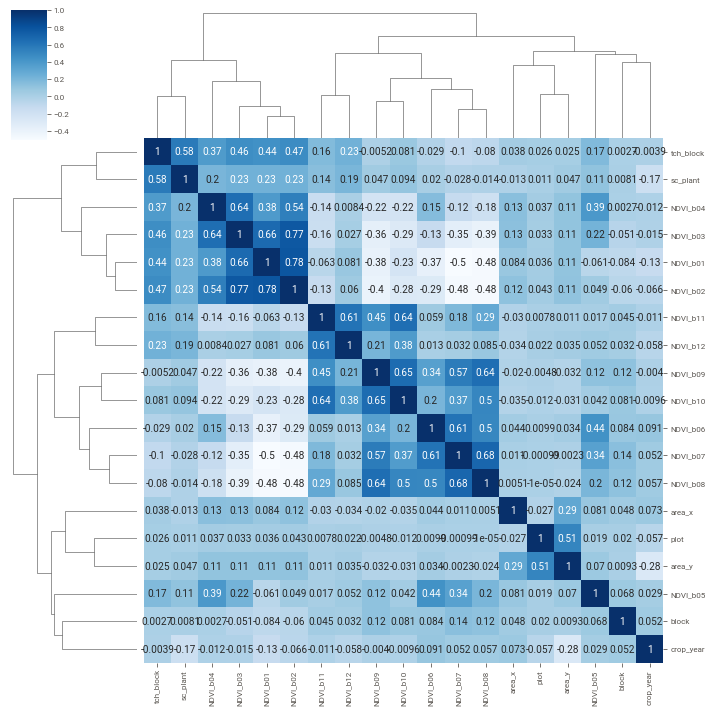

In [90]:
# heat map
corrMatrix = df.corr(method='pearson')
sn.clustermap(corrMatrix, annot=True,
              cmap="Blues", annot_kws={"size": 10})
plt.show()

## Results

&nbsp;

- `tch_block` has a linear relation with some features;
- The feaures more important are: `plant`, `NDVI_b02`, and `NDVI_b04`.
- The ML algorithms will be tested for the model: `tch_block ~ NDVI_b02 + NDVI_b04 + sc_plant`


# Machine Learning algorithms

In [ ]:
# Dividing the dataset into train and test
train, test = train_test_split(df.iloc[:, 5:21])


## Functions to evaluate the ML algorithms

&nbsp;

- Kling-Gupta Efficiency metric;
- Quite used on hydrology sciences.

Basically, KGE is a cost function that reproduces the temporal dynamics (measured by correlation), as well as preserves the distribution of
predictions (measured by bias and variability).


&nbsp;

\begin{equation}
\label{eqn:1}
\mathrm{KGE}=1-\sqrt{\left(\rho-1\right)^2+\left(\beta-1\right)^2+\left(\gamma-1\right)^2},
\end{equation}

$\rho$ is the Pearson correlation coefficient, $\beta$ is the bias ratio

\begin{equation}
\label{eqn:1.1}
\beta=\dfrac{\mu_{\text e}}{\mu_{\text o}},
\end{equation}

and $\gamma$ is the variability ratio

\begin{equation}
\label{eqn:1.2}
\gamma=\dfrac{\mathrm{CV_e}}{\mathrm{CV_o}}=\dfrac{\sigma_{\text e} \mu_{\text o}}{\mu_{\text e} \sigma_{\text o}},
\end{equation}


&nbsp;

where $\mu$ and $\sigma$ are the mean and standard deviation of estimates (e) and observations (o). CV is the coefficient of variation, defined as the
ratio of the standard deviation and the mean.


In [ ]:
# Defining KGE funcion
def kge(y_true, y_pred, return_all=False):
    """
    Kling-Gupta Efficiency
    Corresponding paper:
    Gupta, Kling, Yilmaz, Martinez, 2012, Runoff conditions in the upper Danube basin under an ensemble of climate change scenarios
    output:
        kge: Kling-Gupta Efficiency
    optional_output:
        cc: correlation
        alpha: variability ratio
        beta: ratio of the mean
    """
    cc = np.corrcoef(y_true, y_pred)[0, 1]
    gamma = (np.std(y_pred)/np.mean(y_pred)) / \
            (np.std(y_true)/np.mean(y_true))
    beta = np.sum(y_pred) / np.sum(y_true)
    kge = 1 - np.sqrt((cc - 1)**2 + (gamma - 1)**2 + (beta - 1)**2)
    if return_all:
        return [kge, cc, gamma, beta]
    else:
        return kge

In [ ]:
# Creating a score
kge_score = make_scorer(kge, greater_is_better=True)

In [ ]:
# Defining an evaluation model function 
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(
        model, X, y, scoring=kge_score, cv=cv, n_jobs=-1)

    return scores



In [ ]:
# Choosing features basead on exploratory data analysis
fs = ['NDVI_b02', 'NDVI_b04', 'sc_plant']


In [ ]:
# Train
y_train = train['tch_block']
X_train = train[fs]


# Test
y_test = test['tch_block']
X_test = test[fs]



In [ ]:
# Models
models = [('DT', DecisionTreeRegressor(max_depth=4)), ('LR', LinearRegression()),
          ('Lasso', Lasso()), ('EN', ElasticNet(alpha=0.5, l1_ratio=0.5)),
          ('Ridge', Ridge()), ('ARD', ARDRegression()),
          ('KNN', KNeighborsRegressor()), ('GBR', GradientBoostingRegressor())]
# ('SVR', SVR()),
# ('XGB', XGBRegressor(n_estimators=500, max_depth=4, learning_rate=0.01,
# reg_alpha = 1, reg_lambda = 0.5))]


In [ ]:
# evaluate the models and store results for train dataset
results, names = list(), list()
for i in models:
    scores = evaluate_model(i[1], X_train, y_train)
    results.append(scores)
    names.append(i[0])
    print('>%s %.3f (%.3f)' % (i[0], scores.mean(), scores.std()))

In [ ]:
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=90)
plt.show()

# Algorithms assessment

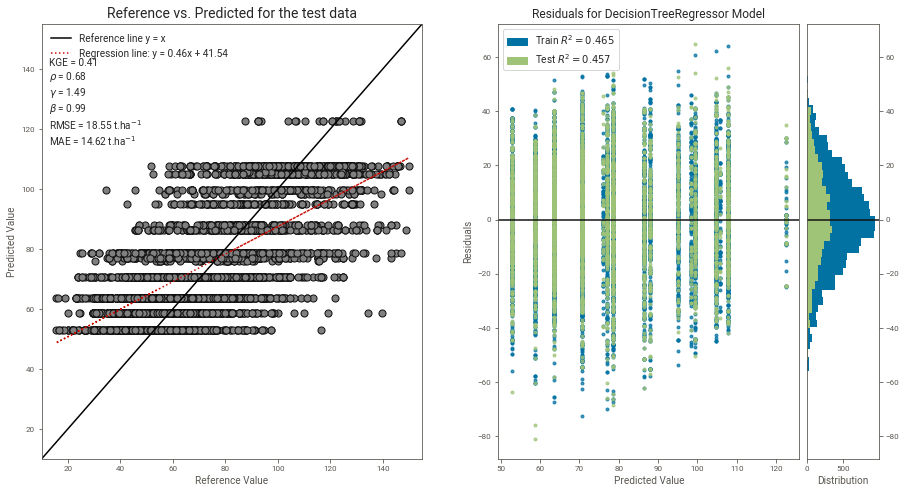

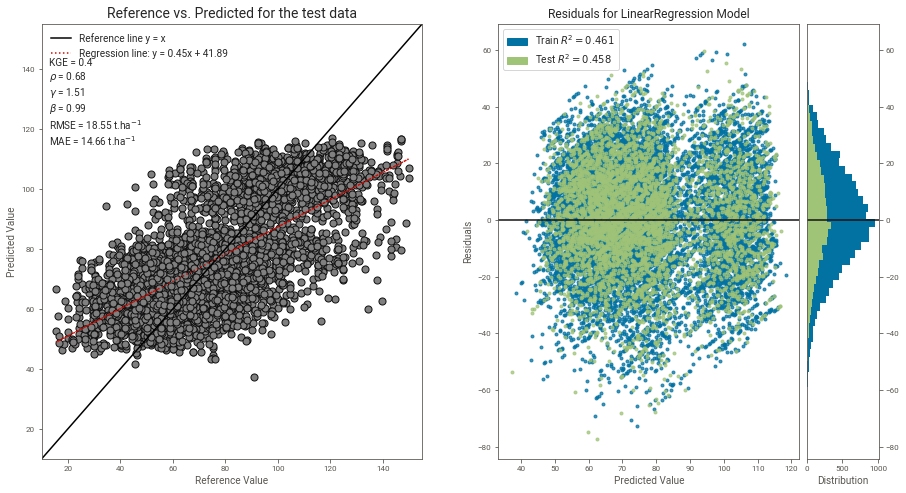

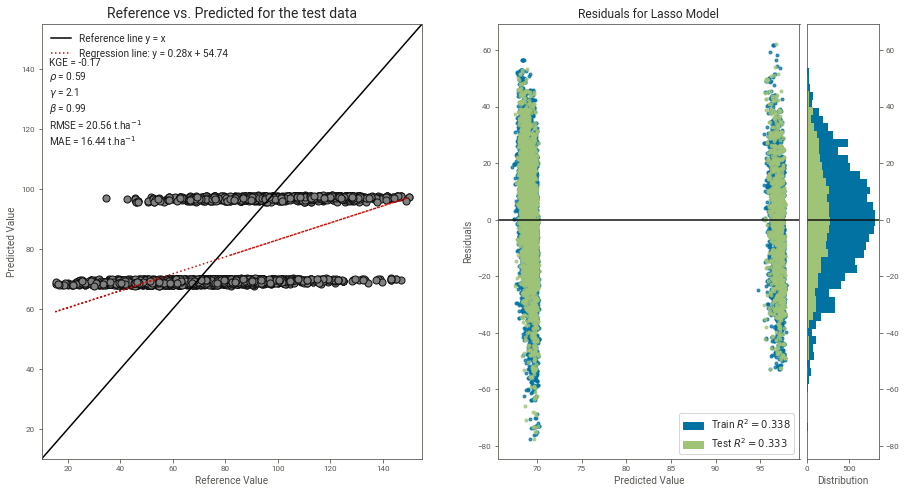

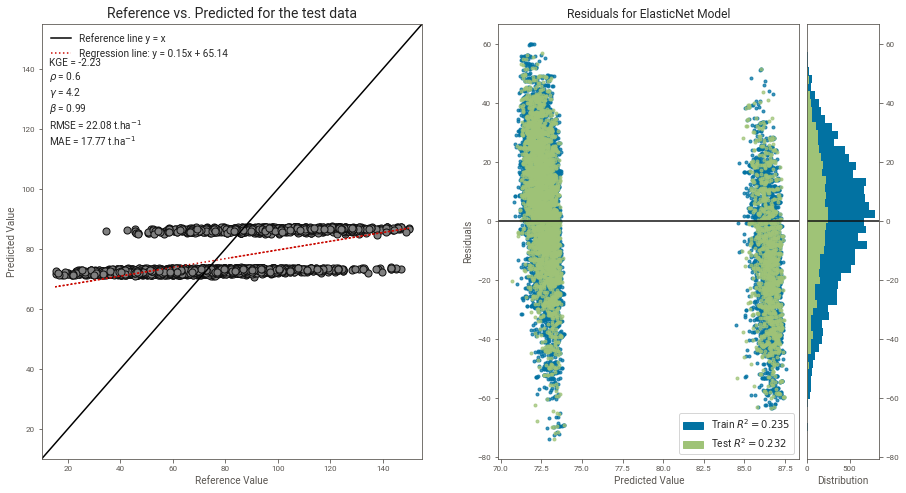

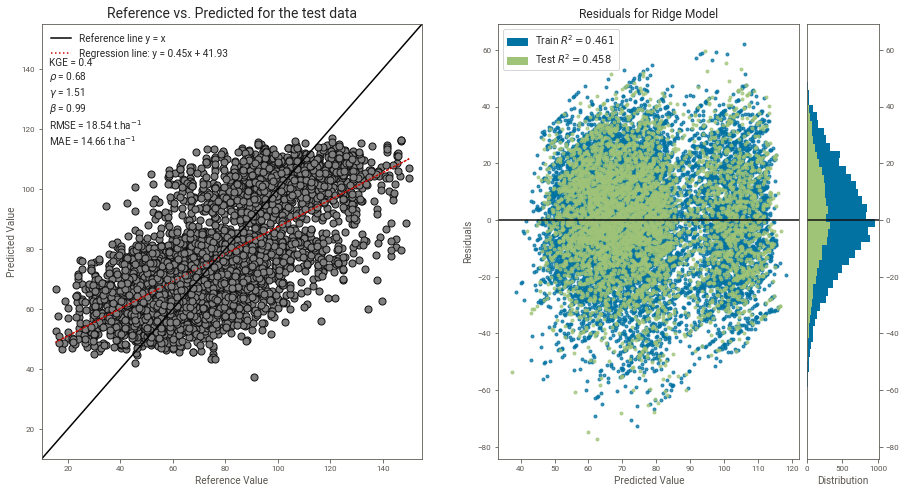

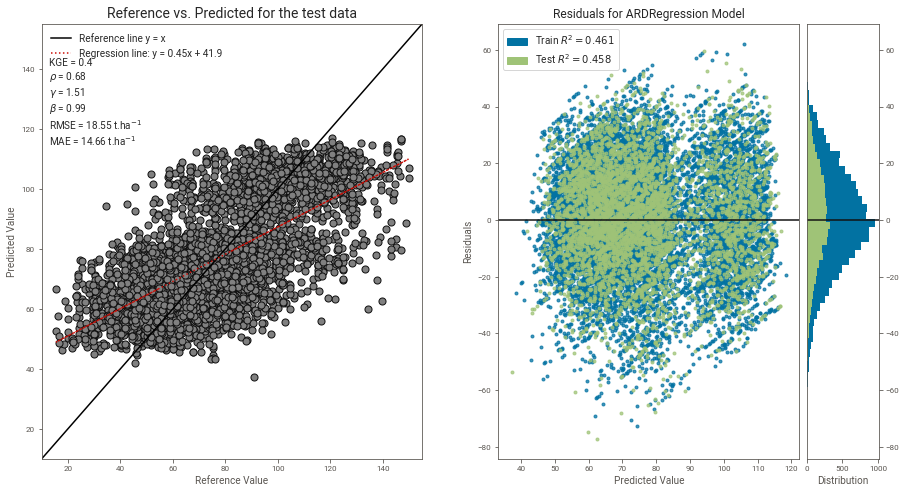

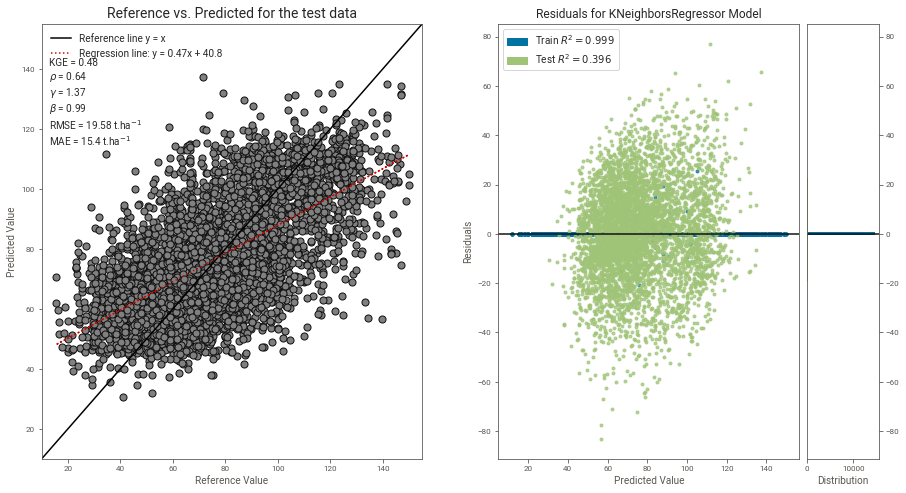

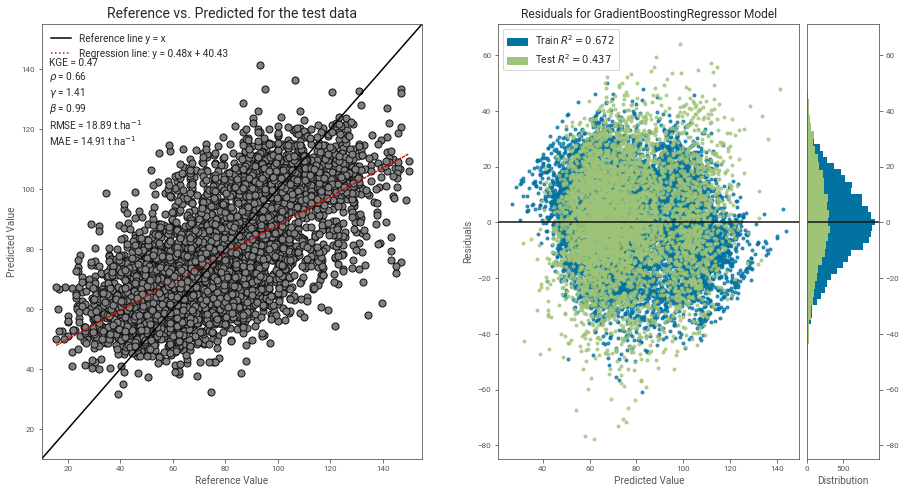

In [91]:
# evaluate the models and store results for test
results, names, models_fit = list(), list(), list()
for i in models:
    models_fit.append(i[1].fit(X_train, y_train))

    # Predicao
    pred = i[1].predict(X_test)
    KGE = kge(pred, y_test, return_all=True)
    GoF = KGE + [np.sqrt(mean_squared_error(
        pred, y_test)), mean_absolute_error(pred, y_test)]
    results.append(GoF)
    names.append(i[0])
    # print('>%s %.3f %.3f %.3f' % (i[0], GoF[0], GoF[1], GoF[2]))
    # Grafico de dispercao com linha 1:1 e residuos
    fig = plt.figure(figsize=(15, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    plt.title("Reference vs. Predicted for the test data", fontsize=14)
    plt.scatter(y_test, pred, s=50, color="gray", edgecolor="k")
    ax_min, ax_max = np.floor(min([y_test.min(), pred.min()]))-5, np.ceil(max(
        [y_test.max(), pred.max()]))+5
    plt.axis([ax_min, ax_max, ax_min, ax_max])
    plt.text(0.02, 0.72, fontsize=10, s='KGE = ' + str(round(GoF[0], 2)) + '\n' +
             r'$\rho$ = ' + str(round(GoF[1], 2)) + '\n' +
             r'$\gamma$ = ' + str(round(GoF[2], 2)) + '\n' +
             r'$\beta$ = ' + str(round(GoF[3], 2)) + '\n' +
             'RMSE = ' + str(round(GoF[4], 2)) + ' t.ha$^{-1}$\n' +
             'MAE = ' + str(round(GoF[5], 2)) + ' t.ha$^{-1}$',
             transform=ax1.transAxes)
    plt.axline((0, 0), slope=1, linestyle='-',
               color="black", label='Reference line y = x')
    m, b = np.polyfit(y_test, pred, 1)
    plt.plot(y_test, m*y_test + b, color="r",
             linestyle='dotted', label='Regression line: y = ' + str(round(m, 2)) + 'x + ' + str(round(b, 2)))
    plt.xlabel("Reference Value")
    plt.ylabel("Predicted Value")
    plt.legend(loc="upper left", )

    ax2 = fig.add_subplot(1, 2, 2)
    viz = residuals_plot(i[1], X_train, y_train, X_test, y_test)
    plt.show()


In [92]:
# Dataframe com os resultados
df_rs = pd.DataFrame(results, index=names, columns=[
    'KGE', 'cc', 'gamma', 'beta', 'RMSE', 'MAE'])

df_rs


,KGE,cc,gamma,beta,RMSE,MAE
DT,0.412447,0.677067,1.490739,0.989636,18.551672,14.615657
LR,0.399394,0.677382,1.506496,0.989633,18.545113,14.656329
Lasso,-0.173097,0.587773,2.098243,0.990602,20.564832,16.437358
EN,-2.229294,0.603960,4.204902,0.990271,22.078328,17.773453
Ridge,0.397729,0.677403,1.508482,0.989640,18.544844,14.656142
ARD,0.399090,0.677373,1.506850,0.989632,18.545368,14.656601
KNN,0.480864,0.637993,1.371884,0.987523,19.580703,15.395869
GBR,0.466611,0.664224,1.414267,0.988125,18.893423,14.906142


## hyperparameters tuning

In [ ]:
# Choosing the best model
id_best = [i for i, x in enumerate(df_rs.RMSE) if x == min(df_rs.RMSE)]
model_best = models[id_best[0]][1]

'''
# hyperparameters tuning KNN
params = {'n_neighbors': np.arange(1, 10), 'metric': [
    'euclidean', 'manhattan'],
    'weights': ['uniform', 'distance']}
'''

# hyperparameters tuning GBR
params = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],
          'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}


# Cross-validation 
cv = RepeatedKFold(
    n_splits=10, n_repeats=3, random_state=12
)

grid = GridSearchCV(estimator=model_best, param_grid=params, cv=cv,
                    scoring=kge_score, n_jobs=-1)

grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)



## Final model

In [ ]:
model_best.set_params(**grid.best_params_)
# Fit the final model to the entire dataset
model_best.fit(df[fs], df['tch_block'])



# Evaluation of the final model

In [ ]:
# Selecting the plots without harvest area 
eng_exe = engine.execute('''
                         SELECT * FROM dataset_final WHERE area_x IS NULL
                         ''').fetchall()

tch_pred = pd.DataFrame(eng_exe, columns=cols)


# Evaluation of the final model
kge(model_best.predict(tch_pred[fs]), tch_pred['tch_block'], return_all=True)
#tch_pred





# Algorithm deployment

## Creating an application program interface (API)

In [ ]:
import os
import pandas as pd
import pickle
from flask import Flask, request


# load model
model = pickle.load(
    open('model/model_tch.pkl', 'rb'))

# instanciate flask
app = Flask(__name__)


# 'POST' send data (y_train), 'GET' just get data
@app.route('/predict', methods=['POST'])
def predict():
    test_json = request.get_json()

    # collect data
    if test_json:
        if isinstance(test_json, dict):  # unique value
            df_raw = pd.DataFrame(test_json, index=[0])
        else:
            df_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

    # prediction
    pred = model.predict(df_raw)
    df_raw['prediction'] = pred

    return df_raw.to_json(orient='records')


# start flask
port = os.environ.get('PORT', 6000)
if __name__ == '__main__':
    app.run(host='0.0.0.0', port=port)


In [ ]:
!tree tch_webapp

## Using API for prediction

In [ ]:
# Reading dataframe from SQLite
engine = create_engine('sqlite:////home/wagner/MEGA/WaterTruth/wagner_portfolio/Project3/datasets/dataset_final.db', echo=False)

eng_exe = engine.execute('''
		SELECT * FROM dataset_final 
                ''').fetchall()

cols = ['block', 'plot', 'crop_year', 'area_x', 'harvest_day',
       'tch_block', 'NDVI_b01', 'NDVI_b02', 'NDVI_b03', 'NDVI_b04', 'NDVI_b05',
       'NDVI_b06', 'NDVI_b07', 'NDVI_b08', 'NDVI_b09', 'NDVI_b10', 'NDVI_b11',
        'NDVI_b12', 'sc_plant',  'area_y']

df = pd.DataFrame(eng_exe, columns=cols)
df.head()

In [ ]:
# Features selection
fs = ['NDVI_b02', 'NDVI_b04', 'sc_plant']

In [ ]:
# 2020 predictions
tch_2020 = df[df['crop_year'] == 2020]
tch_2020


In [ ]:
# for a sample in dataset
sample = df.sample()
sample_json = sample[fs].to_json(orient='records')

In [ ]:
# for 2020 forecast
tch_2020_json = tch_2020[fs].to_json(orient='records')

In [ ]:
# Request in app deployed on the clound > Heroku
# url = 'http://192.168.0.16:6000/predict'  # local
url = 'https://tch-predictions.herokuapp.com/predict'  # heroku cloud
header = {'Content-type': 'application/json'}

In [85]:
# For a sample in the dataset
r_sample = requests.post(url=url, data=sample_json, headers=header)

print('Status code: %.3s \nPrediction: %.3f' % (r_sample.status_code,r_sample.json()[0]['prediction']))
sample[fs]


Status code: 200 
Prediction: 58.017


,NDVI_b02,NDVI_b04,sc_plant
4178,0.447695,0.702964,0


In [ ]:
# For 2020, which was not harvested
r_2020 = requests.post(url=url, data=tch_2020_json, headers=header)
print('Status code: %d' % (r_2020.status_code))


In [84]:
# Evaluation by using API output
df_pred = pd.DataFrame(r_2020.json(), columns=r_2020.json()[0].keys())
print(df_pred)

KGE_api=kge(df_pred['prediction'], tch_2020['tch_block'], return_all=True)
MAE_api=mean_absolute_error(df_pred['prediction'], tch_2020['tch_block'])

print('KGE: %.3f\ncc: %.3f\ngamma: %.3f\nbeta: %.3f\nMAE: %.3f' % (KGE_api[0], KGE_api[1], KGE_api[2], KGE_api[3], MAE_api))



      NDVI_b02  NDVI_b04  sc_plant  prediction
0     0.405134  0.564533         0   49.860000
1     0.357762  0.407766         0   39.024444
2     0.736573  0.767933         1  117.010000
3     0.414752  0.505930         0   52.286667
4     0.447946  0.547397         0   57.497778
...        ...       ...       ...         ...
3395  0.409870  0.538642         0   47.021111
3396  0.785596  0.789238         0   91.570000
3397  0.778086  0.732734         0   88.907778
3398  0.777951  0.598093         0   79.025556
3399  0.748262  0.633632         0   69.577778

[3400 rows x 4 columns]
KGE: 0.532
cc: 0.609
gamma: 1.218
beta: 1.136
MAE: 17.817
